# Economic Performance

This notebook analyzes the economic performance of the United States under different presidents, focusing on various key indicators such as GDP, inflation, unemployment, government debt, and market performance.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Sources

The datasets used in this analysis come from Kaggle. These datasets contain information on U.S. economic indicators, presidents, and market performance from 1980 to 2023.


- [U.S. Economic Indicators 1980-2023](https://www.kaggle.com/datasets/johnbailey123hd/us-economic-indicators-1980-2023)
- [U.S. Economy by Presidents](https://www.kaggle.com/datasets/ogbuzurukelechi/economy-of-the-united-states-by-presidents)
- [List of U.S. Presidents](https://www.kaggle.com/datasets/georgescutelnicu/us-presidents)
- [U.S. Consumer Price Index (CPI) Data 1872-2023](https://www.kaggle.com/datasets/leonardjanke/usa-cpi-data-1872-2023)
- [U.S. Economic indicators in the United States 1974-2024](https://www.kaggle.com/datasets/alfredkondoro/u-s-economic-indicators-1974-2024)


## Helpers

Here are some helper functions to clean up and standardize the data. These functions will make sure the data is easy to analyze.


In [2]:
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Dictionary to map symbols and phrases to their corresponding word representations
    symbol_map = {
        r"\bus\$\b": "usd",
        r"\bnominal\b": "nom",
        r"\bper capita\b": "pc",
        r"\bgovernment\b": "gov",
        "@": "at",
        r"\$": "dollar",
        "#": "number",
        "&": "and",
        "%": "pct",
        r"\*": "star",
        r"\+": "plus",
        r"=": "equals",
    }

    # List of common filler words to remove entirely
    filler_words = [r"\bthe\b", r"\ba\b", r"\ban\b", r"\bof\b", r"\bin\b"]

    # Function to replace symbols with words, remove filler words, and convert to snake_case
    def to_snake_case(col_name: str) -> str:
        # Strip leading and trailing spaces
        col_name = col_name.strip()

        # Remove filler words
        for filler in filler_words:
            col_name = re.sub(filler, "", col_name, flags=re.IGNORECASE)

        # Special case: Handle "US$" placement with underscores
        col_name = re.sub(
            r"(?<!^)(?<!_)\bus\$\b(?!_)(?!$)", r"_usd_", col_name, flags=re.IGNORECASE
        )
        col_name = re.sub(r"^us\$\b(?!_)", r"usd_", col_name, flags=re.IGNORECASE)
        col_name = re.sub(r"\bus\$\b$", r"_usd", col_name, flags=re.IGNORECASE)

        # Replace each symbol or phrase in the dictionary with its corresponding word (case-insensitive)
        for symbol, word in symbol_map.items():
            col_name = re.sub(symbol, word, col_name, flags=re.IGNORECASE)

        # Remove any remaining non-alphanumeric characters except underscores
        col_name = re.sub(r"[^\w\s_]", "", col_name)

        # Replace spaces and dashes with underscores
        col_name = re.sub(r"[\s-]+", "_", col_name)

        # Remove any repeated underscores (i.e., replace multiple underscores with a single one)
        col_name = re.sub(r"_+", "_", col_name)

        # Remove leading or trailing underscores if present
        col_name = col_name.strip("_")

        # Enforce lowercase snake_case column name
        col_name = col_name.lower()

        col_name = re.sub("usdollar", "usd", col_name)
        col_name = re.sub("percent", "pct", col_name)

        return col_name

    # Apply the renaming function to all columns
    df.columns = [to_snake_case(col) for col in df.columns]

    return df


def plot_stat_by_president(
    df, stat_col, y_label, title, label_col="name", figsize=(18, 8)
):
    party_colors = {
        "Democratic": "#2E74B5",  # Democratic Blue
        "Republican": "#E91D0E",  # Republican Red
    }
    # Set the context and figure size directly with seaborn
    sns.set_context("talk", font_scale=1.1)

    # Create the bar plot for the given statistic
    g = sns.catplot(
        x=label_col,
        y=stat_col,
        hue="party",
        data=df,
        kind="bar",
        palette=party_colors,
        height=figsize[1],  # Set height using the figsize
        aspect=figsize[0] / figsize[1],  # Aspect ratio derived from figsize
        legend=False,
    )

    # Set title and labels using the FacetGrid object
    g.set_axis_labels("President", y_label)
    g.fig.suptitle(title, fontsize=16)  # Set the overall title

    # Adjust layout to make sure the title does not overlap with the plot
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.9)  # Adjust top to fit title


def plot_multiple_stats_by_president(
    df,
    stat_cols,
    title,
    label_col="name",
    hue_col="party",
    palette=None,
    figsize=(18, 8),
    orientation="vertical",
):
    """
    Creates multiple bar plots, each showing a different statistic across presidents, colored by party.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        stat_cols (list): A list of column names to plot, each in a separate subplot.
        title (str): The overall title for the entire plot.
        label_col (str): The column to use for the labels (e.g., president names).
        hue_col (str): The column to use for color coding (e.g., party).
        palette (dict): A dictionary mapping hue values to colors.
        figsize (tuple): The size of the overall figure (width, height).
        orientation (str): The orientation of the bars ('vertical' or 'horizontal').
    """

    if palette is None:
        palette = {
            "Democratic": "#2E74B5",  # Democratic Blue
            "Republican": "#E91D0E",  # Republican Red
        }

    # Set the context and figure size directly with seaborn
    sns.set_context("talk", font_scale=1.1)

    # Determine the number of rows based on the number of stat_cols
    num_stats = len(stat_cols)

    # Set up the figure and axes for multiple subplots (one row per stat)
    fig, axes = plt.subplots(num_stats, 1, figsize=figsize, sharex=False)

    # If there's only one stat, axes won't be an array, so we convert it to a list
    if num_stats == 1:
        axes = [axes]

    # Create a bar plot for each stat in stat_cols
    for i, stat in enumerate(stat_cols):
        if orientation == "vertical":
            sns.barplot(
                x=label_col,
                y=stat,
                hue=hue_col,
                data=df,
                palette=palette,
                ax=axes[i],
                legend=False,  # Disable the legend for each subplot
            )
            axes[i].set_ylabel(stat)
            axes[i].set_xlabel("")  # No xlabel for individual plots
        elif orientation == "horizontal":
            sns.barplot(
                x=stat,
                y=label_col,
                hue=hue_col,
                data=df,
                palette=palette,
                ax=axes[i],
                legend=False,  # Disable the legend for each subplot
            )
            axes[i].set_xlabel(stat)
            axes[i].set_ylabel("")  # No ylabel for individual plots

    # Set the overall title
    fig.suptitle(title, fontsize=16)

    # Rotate labels based on the orientation
    # if orientation == "vertical":
    #     plt.xticks(rotation=45, ha="right")
    # else:
    #     plt.yticks(rotation=0)  # Horizontal orientation doesn't need rotated ticks

    # Adjust layout to make sure everything fits well
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)  # Adjust top to fit title

    # Show the plot
    plt.show()

## Datasets

We load several datasets to analyze economic performance. The data includes GDP, inflation rates, unemployment, and market changes, among other key indicators.


In [3]:
economic_growth_df = pd.read_csv("./datasets/USA Economy Growth.csv")
economic_indicators_df = pd.read_csv("./datasets/US_Economic_Indicators.csv")
presidents_df = pd.read_csv("./datasets/presidents.csv")
market_performance_df = pd.read_csv("./datasets/market-performance-by-president_1.csv")
cpi_df = pd.read_csv("./datasets/shiller_cpi_cleaned_for_kaggle.csv")
cpi_data_df = pd.read_csv("./datasets/cpi_data.csv")
gdp_data_df = pd.read_csv("./datasets/gdp_data.csv")
unemployment_data_df = pd.read_csv("./datasets/unemployment_data.csv")
economic_indicators_2_df = cpi_data_df.merge(gdp_data_df, on="DATE", how="inner").merge(
    unemployment_data_df, on="DATE", how="inner"
)

## Data Wrangling

This section cleans and prepares the data for analysis. We ensure that columns are standardized, names are consistent, and the right indices are used.


In [4]:
# Ensure columns use the same conventions
standardize_columns(economic_growth_df)
standardize_columns(economic_indicators_df)
standardize_columns(presidents_df)
standardize_columns(market_performance_df)
standardize_columns(cpi_df)
standardize_columns(economic_indicators_2_df)


economic_indicators_2_df["date_segmented"] = economic_indicators_2_df["date"].str.split(
    "-"
)
economic_indicators_2_df[["year", "month", "day"]] = pd.DataFrame(
    economic_indicators_2_df["date_segmented"].tolist(),
    index=economic_indicators_2_df.index,
)
economic_indicators_2_df = (
    economic_indicators_2_df.groupby(by="year").last().reset_index()
)
economic_indicators_2_df["year"] = economic_indicators_2_df["year"].astype(int)


# Standarize spellings
economic_growth_df["presidents"] = economic_growth_df["presidents"].str.replace(
    "George Bush", "George H. W. Bush"
)
market_performance_df["president"] = market_performance_df["president"].str.replace(
    "George HW Bush", "George H. W. Bush"
)
market_performance_df["president"] = market_performance_df["president"].str.replace(
    "George W Bush", "George W. Bush"
)
market_performance_df["president"] = market_performance_df["president"].str.replace(
    "Joe Biden ", "Joe Biden"
)

# Ensure correct index usage
economic_growth_df.set_index(["presidents"], drop=False, inplace=True)
market_performance_df.set_index(["president"], drop=False, inplace=True)
presidents_df.set_index(["name"], drop=False, inplace=True)

# Built list of modern presidents
president_names = economic_growth_df["presidents"].unique()
relevant_years = economic_growth_df["year"].unique()

In [5]:
modern_presidents_df = presidents_df.query("name in @president_names")
modern_cpi_df = cpi_df.query("year in @relevant_years")[["cpi", "inflation", "year"]]
modern_markets_df = market_performance_df.query("president in @president_names")
modern_markets_df = modern_markets_df.rename(
    columns={
        "amount_change": "dow_amount_change",
        "pct_change": "dow_pct_change",
        "begin_dow": "starting_dow",
        "end_dow": "ending_dow",
        "begin_date": "term_start_date",
        "end_date": "term_end_date",
    }
)

active_columns = [
    # "no",
    "name",
    # "birthplace",
    # "birthday",
    # "life",
    # "height",
    # "children",
    # "religion",
    # "higher_education",
    # "occupation",
    # "military_service",
    # "term",
    "party",
    # "vice_president",
    # "previous_office",
    # "economy",
    # "foreign_affairs",
    # "military_activity",
    # "other_events",
    # "legacy",
    "year",
    "gdp",
    # "gdp_pc_usd_ppp",
    "gdp_bil_usd_nominal",
    "gdp_pc_usd_nom",
    "gdp_growth_pct",
    "inflation_rate_pct",
    "unemployment_pct",
    "gov_debt_pct_gdp",
    # "president",
    # "affliliation",
    # "term_start_date",
    # "starting_dow",
    # "term_end_date",
    # "ending_dow",
    "dow_amount_change",
    "dow_pct_change",
    "cpi",
    # "inflation",
]

# Version 1 of stats (stats_df)
stats_df = modern_presidents_df.join(economic_growth_df).dropna()
stats_df.drop(columns=["presidents"], inplace=True)

stats_df["year"] = stats_df["year"].astype(int)
stats_df["gdp"] = stats_df["gdp"].astype(float)

# Replace percentage strings with numeric values for inflation, unemployment, and debt
stats_df["inflation_rate_pct"] = (
    stats_df["inflation_rate_pct"].str.rstrip("%").astype(float)
)
stats_df["unemployment_pct"] = (
    stats_df["unemployment_pct"].str.rstrip("%").astype(float)
)
stats_df["gov_debt_pct_gdp"] = (
    stats_df["gov_debt_pct_gdp"].str.rstrip("%").astype(float)
)
stats_df = stats_df.join(modern_markets_df)

stats_df = stats_df.merge(modern_cpi_df, how="inner", on="year")

stats_df = stats_df[active_columns]

# Version 2 of stats (economic_stats_df)
economic_stats_df = stats_df[["name", "year", "party"]].merge(
    economic_indicators_2_df, on="year", how="inner"
)
economic_stats_df = economic_stats_df.rename(
    columns={
        "cpiaucsl": "cpi",
        "unrate": "unemployment_rate",
    }
)
economic_stats_df = economic_stats_df[
    ["name", "year", "party", "cpi", "gdp", "unemployment_rate"]
]

## Reports

In this section, we visualize key economic indicators to understand how the economy performed under different U.S. presidents.


### GDP Change

This chart shows how the Gross Domestic Product (GDP) changed during each president's term.

GDP is the total value of all goods and services produced in a country. It is one of the most important indicators of a country's economic health. A higher GDP usually means the economy is growing, while a lower GDP can mean economic problems.


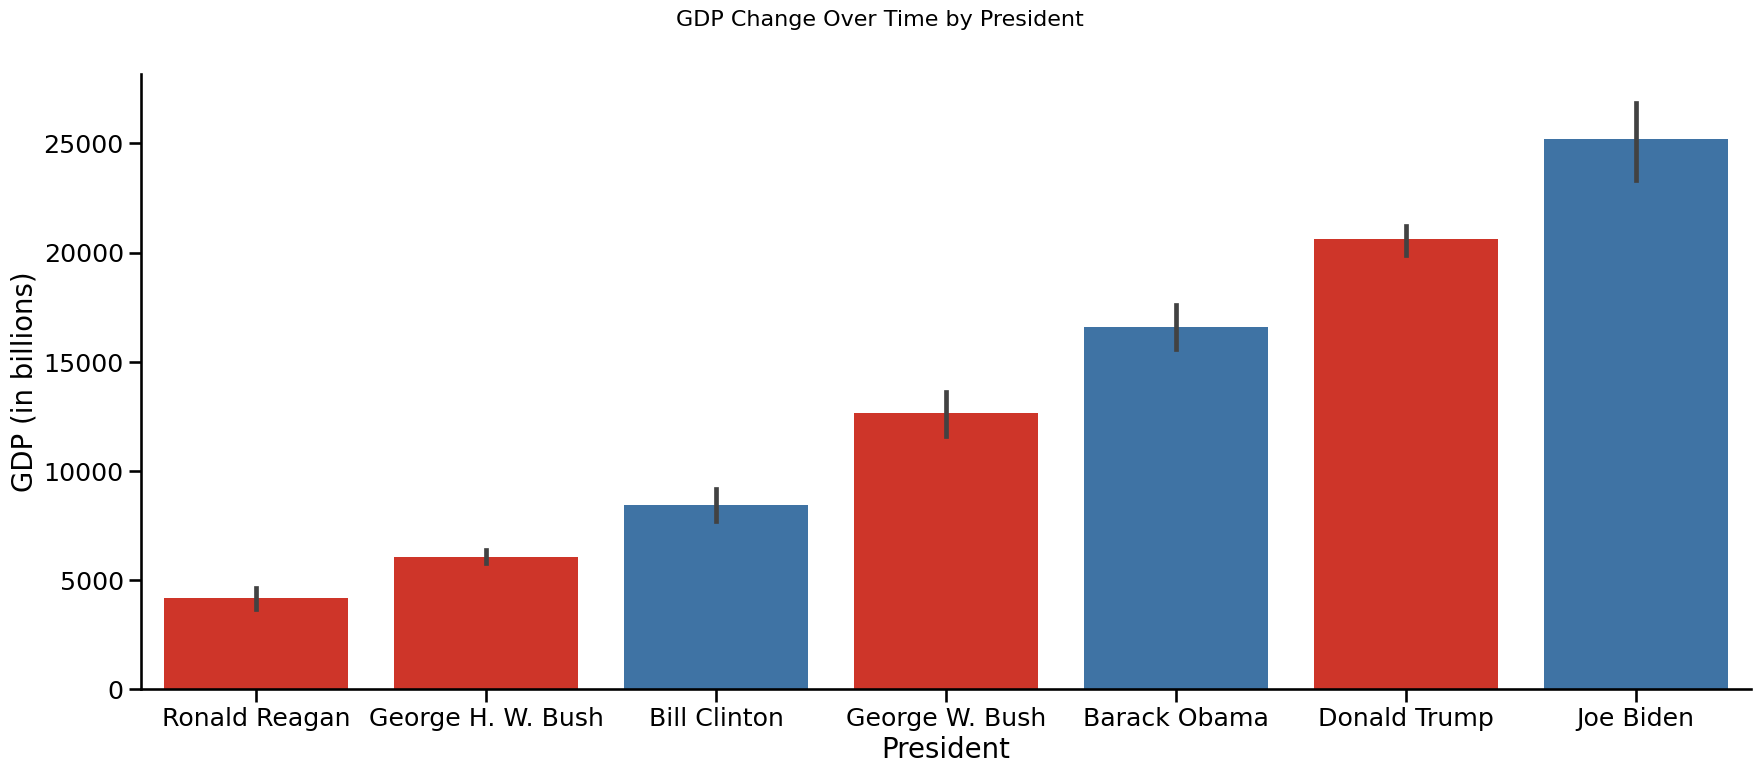

In [6]:
plot_stat_by_president(
    df=stats_df,
    stat_col="gdp",
    y_label="GDP (in billions)",
    title="GDP Change Over Time by President",
)

### Inflation Change

This chart shows the inflation rate during each president's term.

Inflation measures how much the prices of goods and services increase over time. A low inflation rate is generally good because it means prices are stable. High inflation, on the other hand, makes everything more expensive, which can be hard on consumers.


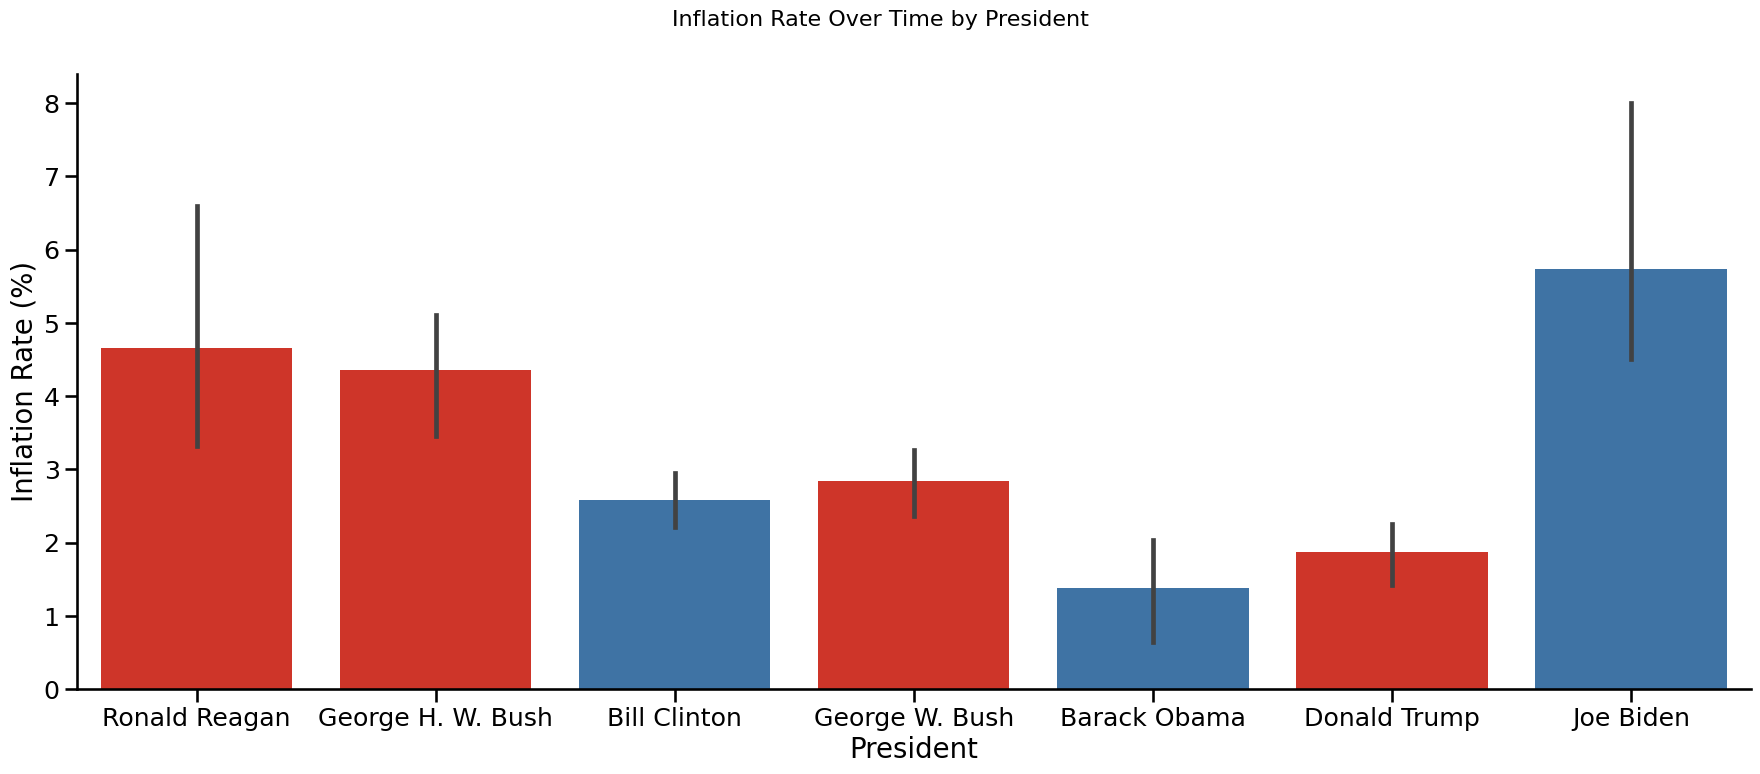

In [7]:
plot_stat_by_president(
    df=stats_df,
    stat_col="inflation_rate_pct",
    y_label="Inflation Rate (%)",
    title="Inflation Rate Over Time by President",
)

### Unemployment Change

This chart shows the unemployment rate during each president's term.

The unemployment rate is the percentage of people who are actively looking for work but cannot find a job. A high unemployment rate usually means the economy is struggling, while a low rate is a sign of a healthy economy where most people can find jobs.


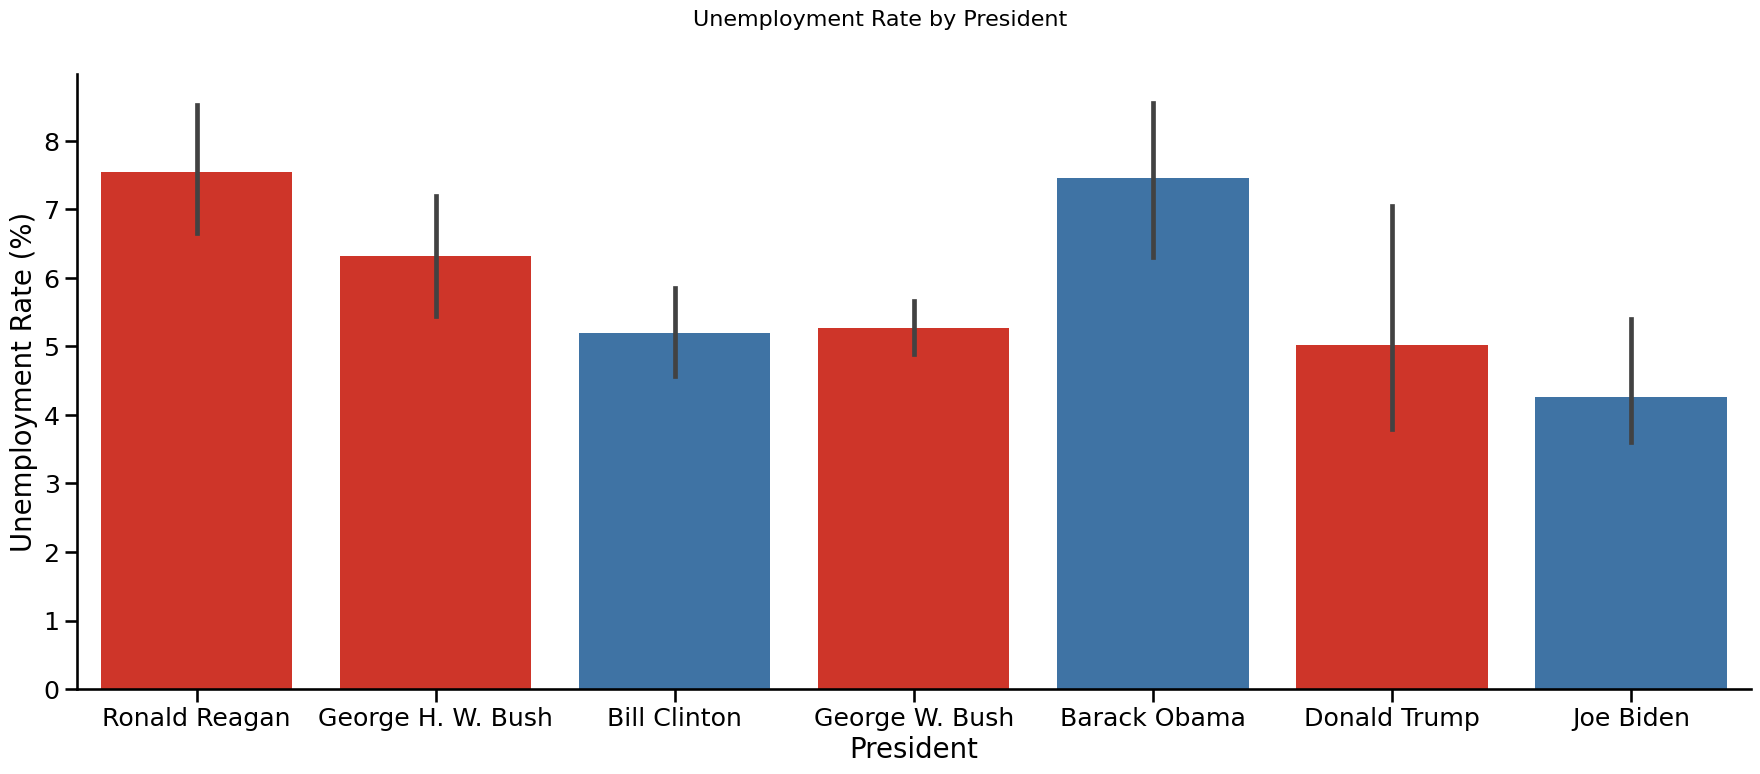

In [8]:
plot_stat_by_president(
    df=stats_df,
    stat_col="unemployment_pct",
    y_label="Unemployment Rate (%)",
    title="Unemployment Rate by President",
)

### Government Debt Change

This chart shows the change in government debt as a percentage of GDP during each president's term.

Government debt is the total amount of money the government owes. When the debt is shown as a percentage of GDP, it tells us how big the debt is compared to the size of the economy. A rising percentage means the government is borrowing more money relative to how much the economy is growing.


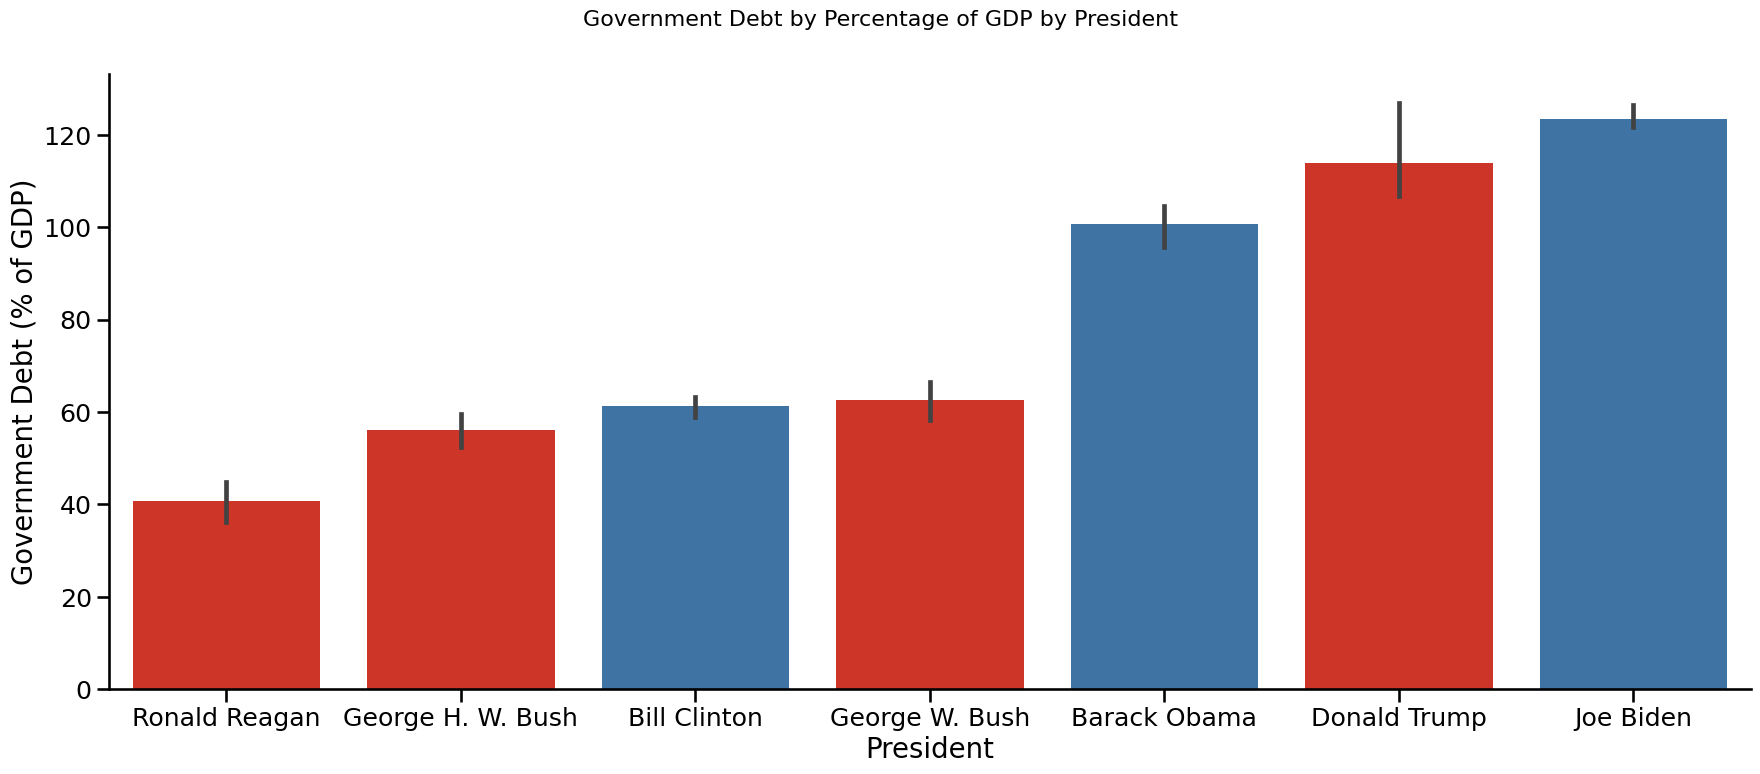

In [9]:
plot_stat_by_president(
    df=stats_df,
    stat_col="gov_debt_pct_gdp",
    y_label="Government Debt (% of GDP)",
    title="Government Debt by Percentage of GDP by President",
)

### Market Change

This chart shows how the stock market, represented by the Dow Jones Index, changed during each president's term.

The Dow Jones Index tracks the performance of major U.S. companies. When the Dow goes up, it means the stock market is doing well, which can signal investor confidence in the economy. A drop in the Dow usually means that companies are struggling and the economy may be weakening.


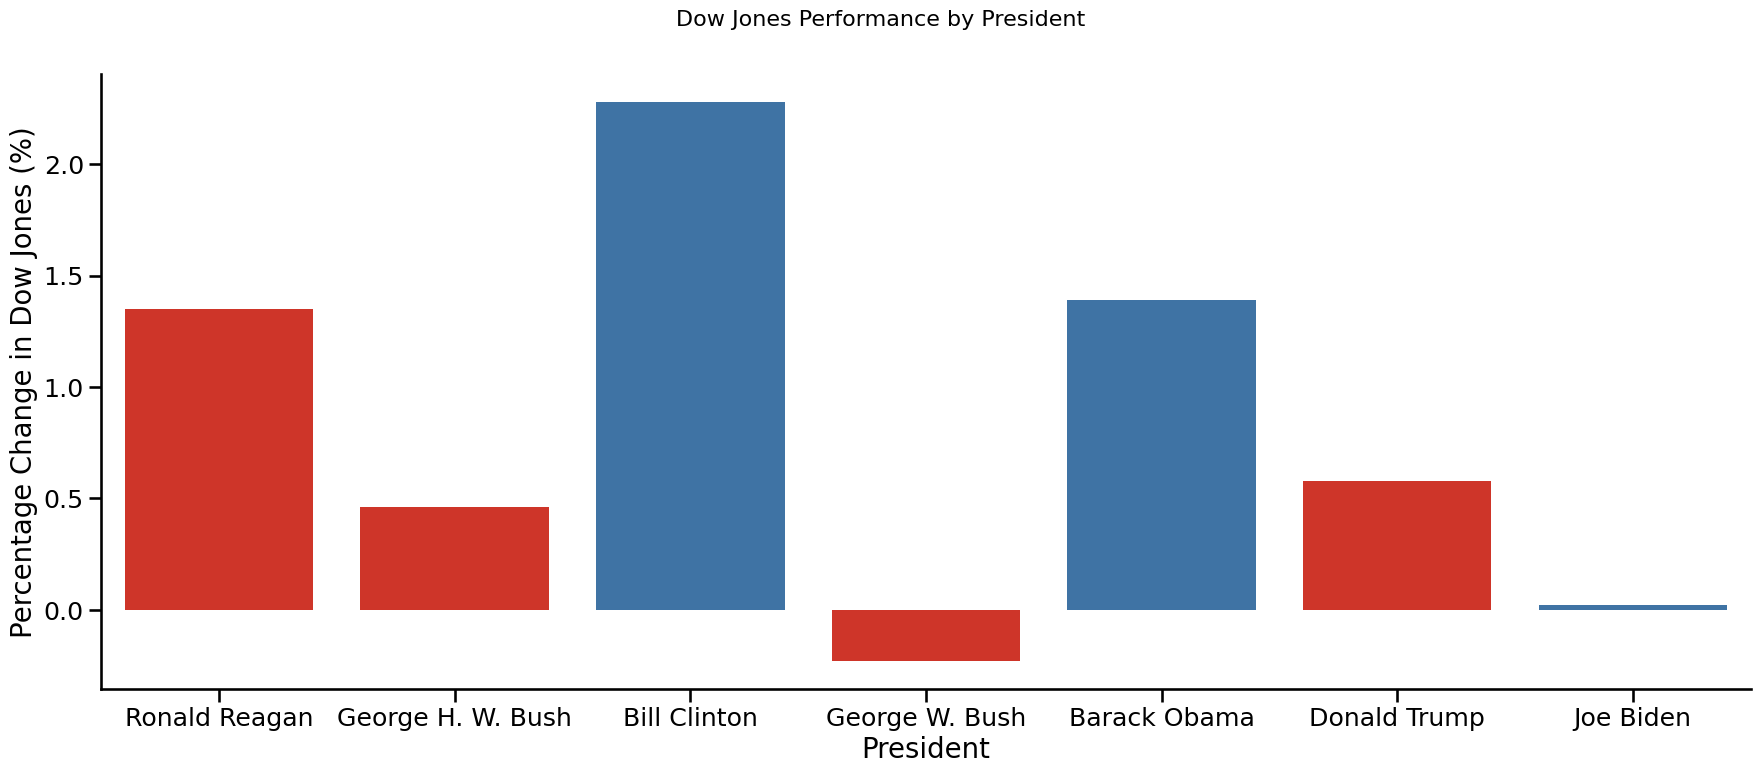

In [10]:
plot_stat_by_president(
    df=stats_df,
    stat_col="dow_pct_change",
    y_label="Percentage Change in Dow Jones (%)",
    title="Dow Jones Performance by President",
)

### CPI Change

This chart shows how the Consumer Price Index (CPI) changed during each president's term.

The CPI measures the average change in prices that consumers pay for everyday goods and services, like food, housing, and transportation. It's a key measure of inflation. When CPI goes up, it means the cost of living is rising.


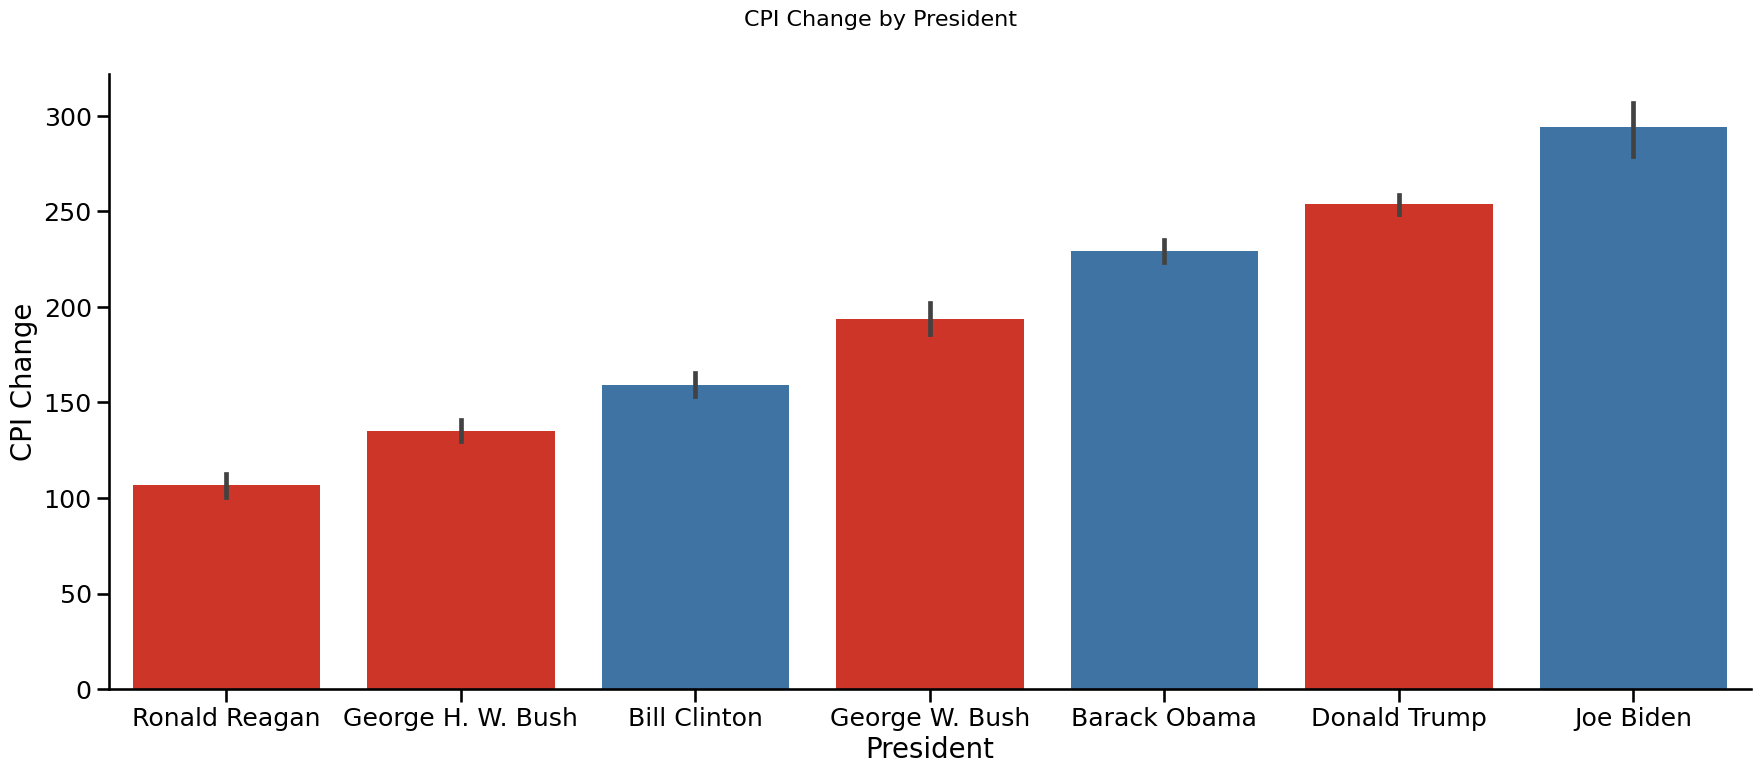

In [11]:
plot_stat_by_president(
    df=stats_df,
    stat_col="cpi",
    y_label="CPI Change",
    title="CPI Change by President",
)

## All Stats by President


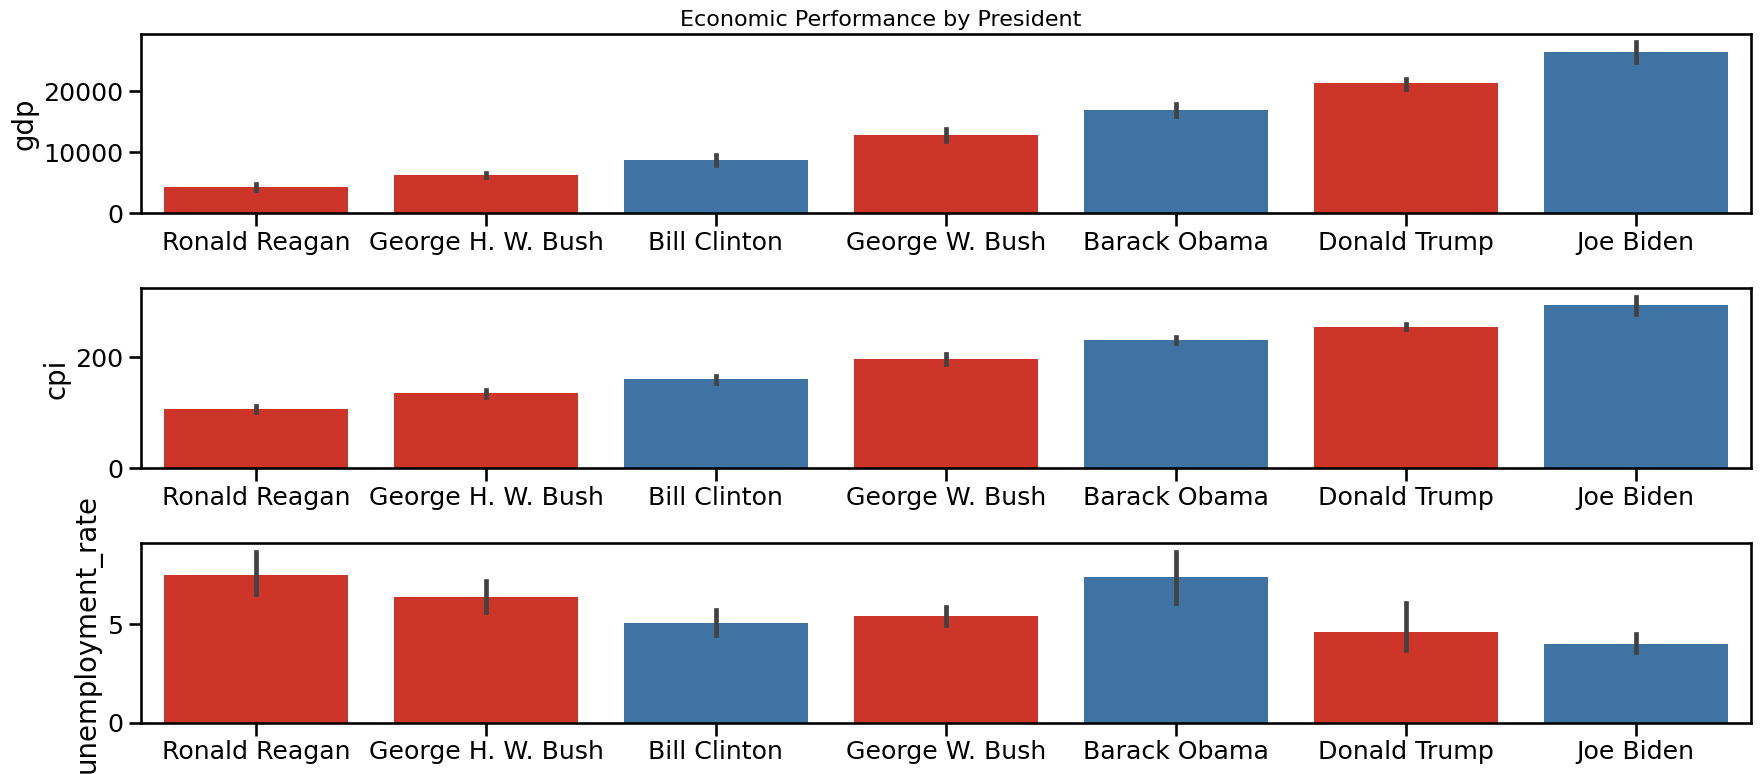

In [12]:
plot_multiple_stats_by_president(
    economic_stats_df,
    stat_cols=["gdp", "cpi", "unemployment_rate"],
    title="Economic Performance by President",
)

## Raw Data


In [13]:
stats_df.head()

,name,party,year,gdp,gdp_bil_usd_nominal,gdp_pc_usd_nom,gdp_growth_pct,inflation_rate_pct,unemployment_pct,gov_debt_pct_gdp,dow_amount_change,dow_pct_change,cpi
0,Ronald Reagan,Republican,1981,3207.0,3207.0,13948.7,2.50%,10.4,7.6,31.0,1285.94,1.35,94.0
1,Ronald Reagan,Republican,1982,3343.8,3343.8,14405.0,-1.80%,6.2,9.7,34.0,1285.94,1.35,97.6
2,Ronald Reagan,Republican,1983,3634.0,3634.0,15513.7,4.60%,3.2,9.6,37.0,1285.94,1.35,101.3
3,Ronald Reagan,Republican,1984,4037.7,4037.7,17086.4,7.20%,4.4,7.5,38.0,1285.94,1.35,105.3
4,Ronald Reagan,Republican,1985,4339.0,4339.0,18199.3,4.20%,3.5,7.2,41.0,1285.94,1.35,109.3


In [14]:
economic_stats_df.head()

,name,year,party,cpi,gdp,unemployment_rate
0,Ronald Reagan,1981,Republican,93.4,3280.818,7.9
1,Ronald Reagan,1982,Republican,98.1,3402.561,10.4
2,Ronald Reagan,1983,Republican,100.8,3794.706,8.8
3,Ronald Reagan,1984,Republican,105.1,4148.551,7.4
4,Ronald Reagan,1985,Republican,108.5,4444.094,7.1
